Coefficients: 
 [ 0.03247063 -0.06557005 -0.00626007  0.01259013 -0.02437114]
R-squared: 0.0031006708252678816
Coverage Probability:  0.9921175206019348


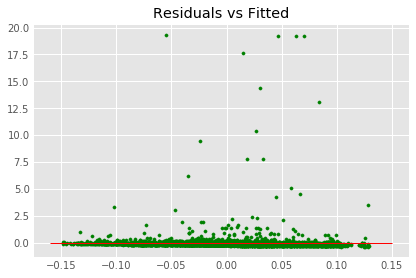

Coverage Probability
 Minimum:  0.9488
 Mean:  0.9906
 Median:  0.991
 Maximum:  0.9946


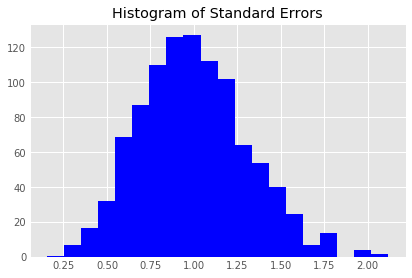

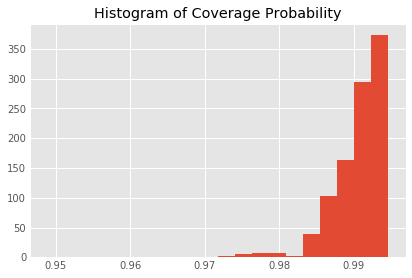

In [304]:
# Stats 506, Fall 2019
# Group Project - group 9
#
# This script aims to explore the relastionship between drinking habits and 
# general health condition for adults over 21 years old in US.
#
# NHANES 2005-2006 Questionnaire Data: Alcohol Use, Current Health Status
# Source: https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Questionnaire&CycleBeginYear=2005
# NHANES 2005-2006 Demographics Data
# Source: https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Demographics&CycleBeginYear=2005
#
# Updated: November 29, 2019
#80: ---------------------------------------------------------------------------

# set up: ----------------------------------------------------------------------
import xport
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import t

# read in the data: ------------------------------------------------------------
## 'rb' mode - opens the file in binary format for reading
with open('HSQ_D.XPT', 'rb') as f:
    df_health = xport.to_dataframe(f)

with open('ALQ_D.XPT', 'rb') as f:
    df_alcohol = xport.to_dataframe(f)

with open('DEMO_D.XPT', 'rb') as f:
    df_demo = xport.to_dataframe(f)
    
# Data preparation: ------------------------------------------------------------
# Extract key columns
df_health = df_health.loc[df_health['HSD010'] <= 3, ['SEQN','HSD010']]
df_alcohol = df_alcohol.loc[df_alcohol['ALQ120Q'] <= 365, ['SEQN','ALQ120Q']]
df_demo = df_demo.loc[(df_demo.RIDAGEYR >= 21) & (df_demo.DMDEDUC2 <= 5), 
                      ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'INDFMPIR', 'DMDEDUC2']]

# Merge key columns into one data frame
df = pd.merge(df_alcohol, df_health, on = 'SEQN')
df = pd.merge(df, df_demo, on = 'SEQN')

# Drop missing values
#df.isnull().sum()
df = df.dropna(axis = 0)

# Rename columns
df = df.rename(columns = {"SEQN": "id", "ALQ120Q": "alcohol", "HSD010": "health",
                          "RIAGENDR": "sex", "RIDAGEYR": "age", "INDFMPIR": "pir",
                          "DMDEDUC2": "edu"})

# normalize and factorize
df.alcohol = (df.alcohol - np.mean(df.alcohol)) / np.std(df.alcohol)
df.age = (df.age - np.mean(df.age)) / np.std(df.age)
df.pir = (df.pir - np.mean(df.pir)) / np.std(df.pir)
df.edu = pd.factorize(df.edu)[0]
df.health = df.health.astype('category')
df['health'].cat.categories = ['3', '2', '1']

# Initial linear regression model: ---------------------------------------------
X = np.array(df.iloc[:,2:])
y = np.array(df.loc[:,'alcohol'])
lmod = LinearRegression().fit(X, y)

# print regression coefficients
print('Coefficients: \n', lmod.coef_)

# print R^2 
print('R-squared: {}'.format(lmod.score(X, y)))

# compute coverage probability
fitted = lmod.predict(X)
res = y - model.predict(X)
tdist_df = df.shape[0] - df.shape[1] -1
se = sum(res**2) / tdist_df
alpha = 0.05
ci = fitted - t.ppf(1 - alpha/2, tdist_df)*se, fitted + t.ppf(1 - alpha/2, tdist_df)*se
coverg_prob = sum((y > ci[0]) & (y < ci[1])) / df.shape[0]
print('Coverage Probability: ', coverg_prob)

# plot residual errors
plt.style.use('ggplot')
plt.scatter(fitted, res, color = "green", s = 10)
plt.hlines(y = 0, xmin = -0.16, xmax = 0.15, linewidth = 1, color = "red")
plt.title("Residuals vs Fitted")
plt.show()

# Function for bootstrapping residuals: ---------------------------------------
# resample residuals with replacement
def boot_coverg_prob(fitted_values, res, tdist_df, alpha = 0.05):
    # input: 
    #   fitted_values - a numpy array of fitted values from the original linear model
    #   res  - a numpy array of residuals from the original linear model
    #   tdist_df - degree of freedom for computing t distribution
    #   alpha - a value between [0,1] representing alpha level of confidence interval
    # output: 
    #   the coverage probability after resampling residuals
    
    b_res = np.random.choice(res, size = len(res), replace = True)
    b_se = sum(b_res**2) / tdist_df
    ci = (fitted_values - t.ppf(1 - alpha/2, tdist_df)*b_se, 
          fitted_values + t.ppf(1 - alpha/2, tdist_df)*b_se)
    coverg_prob = sum((y > ci[0]) & (y < ci[1])) / df.shape[0]
    return(b_se, coverg_prob)

# Test function
#boot_coverg_prob(fitted, res, tdist_df)

# Bootstrapping residuals 1000 times: -----------------------------------------
B = 1000
b = [boot_coverg_prob(fitted, res, tdist_df) for i in range(B)]
b_prob = [lis[1] for lis in b]

print('Coverage Probability')
print(' Minimum: ', round(min(b_prob), 4))
print(' Mean: ', round(np.mean(b_prob), 4))
print(' Median: ', round(np.median(b_prob), 4))
print(' Maximum: ', round(max(b_prob), 4))

# plot the distribution of standard errors
b_se = [lis[0] for lis in b]
plt.style.use('ggplot')
plt.hist(b_se, bins = 20, color = 'blue')
plt.title('Histogram of Standard Errors')
plt.show()

# plot the distribution of coverage probability
plt.style.use('ggplot')
plt.hist(b_prob, bins = 20)
plt.title('Histogram of Coverage Probability')
plt.show()